In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import functional as VF
from torchmetrics.classification import BinaryJaccardIndex
from torchvision import models, datasets, tv_tensors
from torchvision.transforms import v2
import pandas as pd
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import random

In [2]:
class WellsDataset(Dataset):
    def __init__(self, data, labels, transform):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = False
        self.scaler = RobustScaler()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
def build_train_dataframe():
  if os.path.exists('./inputs/x_train_df.csv'):
      return pd.read_csv('inputs/x_train_df.csv')

  data_dir = './train/images/'
  data_dict = []
  pattern = r'well_(\d+)_patch_(\d+)\.npy'
  for i, filename in enumerate(os.listdir(data_dir)):
      example = np.load(data_dir + filename)
      match = re.match(pattern, filename)
      if match:
          well_number = int(match.group(1))  # Extract well number
          patch_number = int(match.group(2)) # Extract patch number
      else:
          print("Filename format does not match the expected pattern.")  

      data_dict.append((filename, well_number, patch_number, example.flatten()))

  df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])

  df_y = pd.read_csv('train/y_train.csv')
  df_y['Unnamed: 0'] = df_y['Unnamed: 0'] + '.npy'

  # Create single dataframe with data and labels as lists
  merged = pd.merge(df, df_y, how='left', left_on='filename', right_on='Unnamed: 0')
  data_columns = [str(i) for i in range(1296)]
  labeled_data = merged[data_columns].to_numpy()
  # Convert missing labels to all zeros
  labeled_data = np.nan_to_num(labeled_data)
  merged['labels'] = labeled_data.tolist()
  merged = merged.rename(columns={'Unnamed: 0':'label_name'})
  merged = merged.fillna(0.0)

  data = torch.from_numpy(np.vstack(merged['data'].to_numpy(dtype=np.ndarray)))
  # Remove corruputed samples
  outliers = ((data.min(dim=1, keepdim=True).values == -999.2500) == True).flatten()

  merged = merged.drop(merged.loc[outliers.tolist()].index)
  merged.to_csv(path_or_buf='./inputs/x_train.csv')
  return merged.sort_values(by=['well_number','patch_number'])

def build_test_dataframe():
  data_dir = './test/images/'
  data_dict = []
  pattern = r'well_(\d+)_patch_(\d+)\.npy'
  for i, filename in enumerate(os.listdir(data_dir)):
      example = np.load(data_dir + filename)
      match = re.match(pattern, filename)
      if match:
          well_number = int(match.group(1))  # Extract well number
          patch_number = int(match.group(2)) # Extract patch number
      else:
          print("Filename format does not match the expected pattern.")  

      data_dict.append((filename, well_number, patch_number, example.flatten()))

  df = pd.DataFrame(data=data_dict, columns=['filename', 'well_number', 'patch_number', 'data'])
  return df.sort_values(by=['well_number','patch_number'])

def build_dataloaders(test_dataframe, train_dataframe):
  test_data = torch.from_numpy(np.vstack(test_dataframe['data'].to_numpy()))
  test_data = torch.nan_to_num(test_data)
  
  train_data = torch.from_numpy(np.vstack(train_dataframe['data'].to_numpy()))
  train_data = torch.nan_to_num(train_data)

  scaler = RobustScaler()
  scaler.fit(train_data)
  
  X_test = torch.tensor(scaler.transform(test_data)).float().reshape(-1, 1, 36, 36)
  X_train = torch.tensor(scaler.transform(train_data)).float().reshape(-1, 1, 36, 36)
  return X_test, X_train


In [43]:
import unet
model = unet.UNet(n_channels=1, n_classes=1)
model.load_state_dict(torch.load('./unet_1.pt', map_location=torch.device('cpu')))
model.eval()
test_df = build_test_dataframe()
train_df = build_train_dataframe()
X_test, X_train = build_dataloaders(test_df, train_df)

In [50]:
well_5_train = train_df[train_df['well_number'] == 5]['data']
well_5_train = torch.from_numpy(np.vstack(well_5_train.values)).reshape(-1, 1, 36, 36)

In [35]:
well_5_labels = train_df[train_df['well_number'] == 5]['labels']
well_5_labels = torch.from_numpy(np.vstack(well_5_labels.values)).reshape(-1, 1, 36, 36).float()

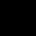

In [84]:
preds = (F.sigmoid(model(torch.from_numpy(train_df.loc[300]['data']).reshape(-1,1,36,36))) > .5)*1.
VF.to_pil_image(preds.view(-1, 36, 36))

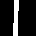

In [85]:
label = torch.from_numpy(np.vstack(train_df.loc[300]['labels'])).reshape(1,36,36).float()
VF.to_pil_image(label)